In [1]:
from misc import HP
import argparse
import random
import time
import pickle
import copy
import SYCLOP_env as syc
from misc import *
import sys
import os
import cv2
import argparse
import tensorflow.keras as keras

from keras_networks import rnn_model_102, rnn_model_multicore_201, rnn_model_multicore_202
from curriculum_utils import create_mnist_dataset, bad_res102

In [2]:

def generate_trajectory(n_steps,max_q,acceleration_mode):
    starting_point = np.array([max_q[0] // 2, max_q[1] // 2])
    steps = []
    qdot=0
    for j in range(n_steps):
        steps.append(starting_point * 1)
        if acceleration_mode:
            qdot += np.random.randint(-1, 2, 2)
            starting_point += qdot
        else:
            starting_point += np.random.randint(-5, 6, 2)
    return np.array(steps)

In [3]:
def split_dataset_xy(dataset):
    dataset_x1 = [uu[0] for uu in dataset]
    dataset_x2 = [uu[1] for uu in dataset]
    dataset_y = [uu[-1] for uu in dataset]
    return (np.array(dataset_x1)[...,np.newaxis],np.array(dataset_x2)[:,:n_timesteps,:]),np.array(dataset_y)

#parse hyperparameters

lsbjob = os.getenv('LSB_JOBID')
lsbjob = '' if lsbjob is None else lsbjob

hp = HP()
hp.save_path = 'saved_runs'
hp.description=''
parser = argparse.ArgumentParser()
parser.add_argument('--tau_int', default=4., type=float, help='Integration timescale for adaaptation')
parser.add_argument('--resize', default=1.0, type=float, help='resize of images')
parser.add_argument('--run_name_suffix', default='', type=str, help='suffix for runname')
parser.add_argument('--eval_dir', default=None, type=str, help='eval dir')

parser.add_argument('--dqn_initial_network', default=None, type=str, help='dqn_initial_network')
parser.add_argument('--decoder_initial_network', default=None, type=str, help='decoder_initial_network')
parser.add_argument('--decoder_arch', default='default', type=str, help='decoder_network architecture: default / multicore_201')
parser.add_argument('--decoder_n_cores',  default=1, type=int, help='decoder number of cores')

parser.add_argument('--decoder_learning_rate',  default=1e-3, type=float, help='decoder learning rate')
parser.add_argument('--decoder_dropout',  default=0.0, type=float, help='decoder dropout')
parser.add_argument('--decoder_rnn_type',  default='gru', type=str, help='gru or rnn')
parser.add_argument('--decoder_rnn_units',  default=100, type=int, help='decoder rnn units')
parser.add_argument('--decoder_rnn_layers',  default=1, type=int, help='decoder rnn units')


parser.add_argument('--decoder_ignore_position', dest='decoder_ignore_position', action='store_true')
parser.add_argument('--no-decoder_ignore_position', dest='decoder_ignore_position', action='store_false')

parser.add_argument('--syclop_learning_rate',  default=2.5e-3, type=float, help='syclop (RL) learning rate')

parser.add_argument('--color', default='grayscale', type=str, help='grayscale/rgb')
parser.add_argument('--speed_reward',  default=0.0, type=float, help='speed reward, typically negative')
parser.add_argument('--intensity_reward',  default=0.0, type=float, help='speed penalty reward')
parser.add_argument('--loss_reward',  default=-1.0, type=float, help='reward for loss, typically negative')
parser.add_argument('--resolution',  default=28, type=int, help='resolution')
parser.add_argument('--max_eval_episodes',  default=10000, type=int, help='episodes for evaluation mode')
parser.add_argument('--steps_per_episode',  default=9, type=int, help='time steps in each episode in ')
parser.add_argument('--fit_verbose',  default=1, type=int, help='verbose level for model.fit                        ')
parser.add_argument('--steps_between_learnings',  default=100, type=int, help='steps_between_learnings')
parser.add_argument('--num_epochs',  default=100, type=int, help='steps_between_learnings')

parser.add_argument('--alpha_increment',  default=0.01, type=float, help='reward for loss, typically negative')


parser.add_argument('--beta_t1',  default=400000, type=int, help='time rising bete')
parser.add_argument('--beta_t2',  default=700000, type=int, help='end rising beta')
parser.add_argument('--beta_b1',  default=0.1, type=float, help='beta initial value')
parser.add_argument('--beta_b2',  default=1.0, type=float, help='beta final value')

parser.add_argument('--curriculum_enable', dest='curriculum_enable', action='store_true')
parser.add_argument('--no-curriculum_enable', dest='curriculum_enable', action='store_false')

parser.add_argument('--conv_fe', dest='conv_fe', action='store_true')
parser.add_argument('--no-conv_fe', dest='conv_fe', action='store_false')

parser.add_argument('--acceleration_mode', dest='acceleration_mode', action='store_true')
parser.add_argument('--no-acceleration_mode', dest='acceleration_mode', action='store_false')


parser.set_defaults(eval_mode=False, decode_from_dvs=False,test_mode=False,rising_beta_schedule=True,decoder_ignore_position=False, curriculum_enable=True, conv_fe=False,
                    acceleration_mode=True)
config = parser.parse_args('')

# config = parser.parse_args()
config = vars(config)
hp.upadte_from_dict(config)
hp.this_run_name = sys.argv[0] + '_noname_' + hp.run_name_suffix + '_' + lsbjob + '_' + str(int(time.time()))

#define model
n_timesteps = hp.steps_per_episode

##
# deploy_logs()
##
# if hp.decoder_arch == 'multicore_201':
#     decoder = rnn_model_multicore_201(n_cores=hp.decoder_n_cores,lr=hp.decoder_learning_rate,ignore_input_B=hp.decoder_ignore_position,dropout=hp.decoder_dropout,rnn_type=hp.decoder_rnn_type,
#                                 input_size=(hp.resolution,hp.resolution, 1),rnn_layers=hp.decoder_rnn_layers,conv_fe=hp.conv_fe, rnn_units=hp.decoder_rnn_units, n_timesteps=hp.steps_per_episode)
# if hp.decoder_arch == 'multicore_202':
#     decoder = rnn_model_multicore_202(n_cores=hp.decoder_n_cores, lr=hp.decoder_learning_rate,
#                                       ignore_input_B=hp.decoder_ignore_position, dropout=hp.decoder_dropout,
#                                       rnn_type=hp.decoder_rnn_type,
#                                       input_size=(hp.resolution, hp.resolution, 1),
#                                       rnn_layers=hp.decoder_rnn_layers, conv_fe=hp.conv_fe,
#                                       rnn_units=hp.decoder_rnn_units, n_timesteps=hp.steps_per_episode)
# elif hp.decoder_arch == 'default':
#     decoder = rnn_model_102(lr=hp.decoder_learning_rate,ignore_input_B=hp.decoder_ignore_position,dropout=hp.decoder_dropout,rnn_type=hp.decoder_rnn_type,
#                                 input_size=(hp.resolution,hp.resolution, 1),rnn_layers=hp.decoder_rnn_layers,conv_fe=hp.conv_fe,rnn_units=hp.decoder_rnn_units, n_timesteps=hp.steps_per_episode)
decoder_initial_network = 'saved_runs/trajectory_curriculum101.py_noname__200012_1624129553_1/final_decoder.nwk'
decoder = keras.models.load_model(decoder_initial_network)
    #define dataset
(images, labels), (images_test, labels_test) = keras.datasets.mnist.load_data(path="mnist.npz")


#fit one epoch in a  time
# scheduler = Scheduler(hp.lambda_schedule)
# for epoch in range(hp.num_epochs):
#     lambda_epoch = scheduler.step(epoch)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [4]:
hp.acceleration_mode

True

In [5]:
alpha=0
hp.num_trials = 100
trajectories = []
train_pred_pred = []
val_pred_pred = []
for trial in range(hp.num_trials):
    this_trajectory=generate_trajectory(hp.steps_per_episode,[72,72],hp.acceleration_mode)
#     this_trajectory=trajectories[trial]
    train_dataset, test_dataset = create_mnist_dataset(images, labels, 6, sample=hp.steps_per_episode, bad_res_func=bad_res102,
                                                           return_datasets=True, q_0=this_trajectory, alpha=0.0,
                                                           random_trajectories=True,acceleration_mode=hp.acceleration_mode)
    train_dataset_x, train_dataset_y = split_dataset_xy(train_dataset)
    test_dataset_x, test_dataset_y = split_dataset_xy(test_dataset)
    q_prime = train_dataset_x[1][0]
#     print('epoch', epoch, '  CONTROL!!!',' first q --', q_prime.reshape([-1]))

    print("evaluating trajectory  ", trial)
    train_preds = decoder.predict(
        train_dataset_x,
        batch_size=64,
        verbose=hp.fit_verbose,
        # We pass some validation for
        # monitoring validation loss and metrics
        # at the end of each epoch
        )
    val_preds = decoder.predict(
        test_dataset_x,
        batch_size=64,
        verbose=hp.fit_verbose,
        # We pass some validation for
        # monitoring validation loss and metrics
        # at the end of each epoch
        )
    accuracy =  np.mean(np.argmax(val_preds, axis=1)==test_dataset_y)
    print('accuracy:', accuracy)
    trajectories.append(this_trajectory+0.)
    train_pred_pred.append(train_preds+0.0)
    val_pred_pred.append(val_preds+0.0)

Are we random? 16
evaluating trajectory   0
5000/5000 [==============================] - 2s 403us/sample
accuracy: 0.7894
Are we random? 19
evaluating trajectory   1
5000/5000 [==============================] - 2s 392us/sample
accuracy: 0.8456
Are we random? 5
evaluating trajectory   2
5000/5000 [==============================] - 2s 403us/sample
accuracy: 0.8606
Are we random? 9
evaluating trajectory   3
5000/5000 [==============================] - 2s 396us/sample
accuracy: 0.8654
Are we random? 4
evaluating trajectory   4
5000/5000 [==============================] - 2s 398us/sample
accuracy: 0.8108
Are we random? 10
evaluating trajectory   5
5000/5000 [==============================] - 2s 395us/sample
accuracy: 0.893
Are we random? 19
evaluating trajectory   6
5000/5000 [==============================] - 2s 392us/sample
accuracy: 0.8592
Are we random? 16
evaluating trajectory   7
5000/5000 [==============================] - 2s 385us/sample
accuracy: 0.8212
Are we random? 3
evaluating 

evaluating trajectory   44
5000/5000 [==============================] - 2s 412us/sample
accuracy: 0.8654
Are we random? 18
evaluating trajectory   45
5000/5000 [==============================] - 2s 419us/sample
accuracy: 0.7956
Are we random? 11
evaluating trajectory   46
5000/5000 [==============================] - 2s 418us/sample
accuracy: 0.7628
Are we random? 10
evaluating trajectory   47
5000/5000 [==============================] - 2s 382us/sample
accuracy: 0.8
Are we random? 4
evaluating trajectory   48
5000/5000 [==============================] - 2s 391us/sample
accuracy: 0.8468
Are we random? 18
evaluating trajectory   49
5000/5000 [==============================] - 2s 420us/sample
accuracy: 0.8114
Are we random? 13
evaluating trajectory   50
5000/5000 [==============================] - 2s 415us/sample
accuracy: 0.8492
Are we random? 15
evaluating trajectory   51
5000/5000 [==============================] - 2s 420us/sample
accuracy: 0.82
Are we random? 17
evaluating trajectory 

evaluating trajectory   88
5000/5000 [==============================] - 2s 413us/sample
accuracy: 0.79
Are we random? 17
evaluating trajectory   89
5000/5000 [==============================] - 2s 408us/sample
accuracy: 0.8242
Are we random? 11
evaluating trajectory   90
5000/5000 [==============================] - 2s 412us/sample
accuracy: 0.8368
Are we random? 4
evaluating trajectory   91
5000/5000 [==============================] - 2s 415us/sample
accuracy: 0.8696
Are we random? 6
evaluating trajectory   92
5000/5000 [==============================] - 2s 410us/sample
accuracy: 0.8628
Are we random? 1
evaluating trajectory   93
5000/5000 [==============================] - 2s 411us/sample
accuracy: 0.6566
Are we random? 4
evaluating trajectory   94
5000/5000 [==============================] - 2s 407us/sample
accuracy: 0.8286
Are we random? 16
evaluating trajectory   95
5000/5000 [==============================] - 2s 409us/sample
accuracy: 0.7714
Are we random? 3
evaluating trajectory  

In [7]:
accuracy =  np.mean(np.argmax(preds, axis=1)==test_dataset_y)

NameError: name 'preds' is not defined

In [8]:
accuracy

0.794

In [10]:
ent = np.zeros([np.shape(test_dataset_y)[0],hp.num_trials])
lablab = np.zeros([np.shape(test_dataset_y)[0],hp.num_trials])
for jj,preds in enumerate(val_pred_pred):
    ent[:,jj]=np.sum(-preds*np.log(preds),axis=1)
    lablab[:,jj]=np.argmax(preds, axis=1)

In [50]:
ii=np.argmin(ent,axis=1)

In [71]:
best_lbl=[]
for jj,uu in enumerate(ii):
    best_lbl.append(lablab[jj,uu])


In [73]:
np.mean(best_lbl==test_dataset_y)

0.9106

In [58]:
np.mean(lablab==test_dataset_y.reshape([-1,1]))

0.8463933333333333

In [60]:
np.mean(lablab==test_dataset_y.reshape([-1,1]),axis=0)

array([0.8198, 0.8732, 0.8654, 0.8316, 0.8712, 0.8718, 0.8754, 0.8258,
       0.8574, 0.8618, 0.8706, 0.8418, 0.85  , 0.8206, 0.8236, 0.8408,
       0.7978, 0.8508, 0.8704, 0.8428, 0.793 , 0.8672, 0.8152, 0.84  ,
       0.8158, 0.8992, 0.8418, 0.8696, 0.8614, 0.826 ])

In [63]:
best_ii=np.argmax(np.mean(lablab==test_dataset_y.reshape([-1,1]),axis=0))

In [65]:
np.mean(ii==best_ii)

0.0772

In [70]:
np.mean(np.any(lablab==test_dataset_y.reshape([-1,1]),axis=1))

0.9932

In [74]:
best_ent=np.min(ent,axis=1)

(array([3.054e+03, 7.410e+02, 3.950e+02, 2.450e+02, 1.690e+02, 1.170e+02,
        9.000e+01, 6.600e+01, 3.500e+01, 3.100e+01, 2.000e+01, 1.300e+01,
        1.200e+01, 5.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00]),
 array([0.0018796 , 0.05121257, 0.10054555, 0.14987852, 0.19921149,
        0.24854446, 0.29787743, 0.34721041, 0.39654338, 0.44587635,
        0.49520932, 0.54454229, 0.59387527, 0.64320824, 0.69254121,
        0.74187418, 0.79120715, 0.84054012, 0.8898731 , 0.93920607,
        0.98853904]),
 <a list of 20 Patch objects>)

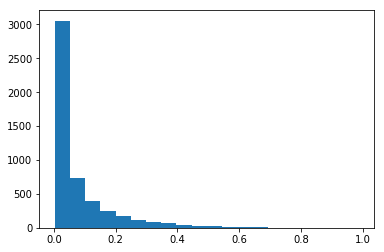

In [77]:
_=plt.hist(best_ent,bins=20)

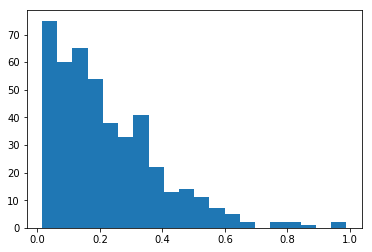

In [78]:
_=plt.hist(best_ent[best_lbl!=test_dataset_y],bins=20)

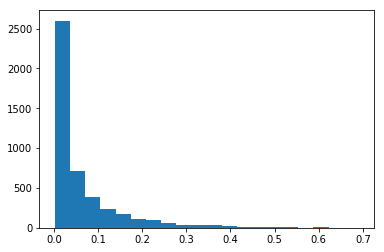

In [79]:
_=plt.hist(best_ent[best_lbl==test_dataset_y],bins=20)

In [85]:
super_pred=np.sum(pred_pred,axis=0)

In [86]:
super_label=np.argmax(super_pred,axis=1)

In [87]:
np.mean(super_label==test_dataset_y)

0.942

In [84]:
super_label.shape

(30,)

In [88]:
with open('committee103_traj_30.pkl','wb') as f:
    pickle.dump(trajectories,f)

In [90]:
trajectories

[array([[36., 36.],
        [36., 36.],
        [36., 36.],
        [35., 35.],
        [35., 34.],
        [34., 34.],
        [34., 35.],
        [33., 37.],
        [31., 38.]]), array([[36., 36.],
        [37., 37.],
        [39., 39.],
        [41., 40.],
        [43., 40.],
        [46., 40.],
        [49., 39.],
        [53., 38.],
        [58., 37.]]), array([[36., 36.],
        [35., 36.],
        [33., 35.],
        [30., 34.],
        [28., 32.],
        [25., 30.],
        [21., 29.],
        [18., 27.],
        [15., 24.]]), array([[36., 36.],
        [35., 35.],
        [35., 34.],
        [36., 32.],
        [38., 29.],
        [40., 25.],
        [43., 21.],
        [47., 18.],
        [50., 15.]]), array([[36., 36.],
        [36., 37.],
        [37., 39.],
        [38., 41.],
        [39., 44.],
        [40., 46.],
        [40., 48.],
        [39., 50.],
        [39., 51.]]), array([[36., 36.],
        [35., 37.],
        [33., 38.],
        [31., 38.],
        [30., 3

In [92]:
trajectories[25]

array([[36., 36.],
       [37., 35.],
       [37., 34.],
       [38., 32.],
       [40., 31.],
       [42., 30.],
       [43., 29.],
       [44., 28.],
       [46., 27.]])

In [15]:
def super_pred_fun(pred,T=1):
    logits = np.log(pred)
    pred_T = np.exp(1./T*logits)
    pred_T = pred_T/np.sum(pred_T,axis=-1)[...,np.newaxis]
    super_pred=np.sum(pred_T,axis=0)
    return super_pred

In [16]:
super_pred = super_pred_fun(train_pred_pred)

In [17]:
super_pred = super_pred_fun(val_pred_pred,T=1000)
super_label=np.argmax(super_pred,axis=1)
print(np.mean(super_label==test_dataset_y))

0.9458


In [109]:
np.linspace(0.1,5.0,100)

array([0.1       , 0.14949495, 0.1989899 , 0.24848485, 0.2979798 ,
       0.34747475, 0.3969697 , 0.44646465, 0.4959596 , 0.54545455,
       0.59494949, 0.64444444, 0.69393939, 0.74343434, 0.79292929,
       0.84242424, 0.89191919, 0.94141414, 0.99090909, 1.04040404,
       1.08989899, 1.13939394, 1.18888889, 1.23838384, 1.28787879,
       1.33737374, 1.38686869, 1.43636364, 1.48585859, 1.53535354,
       1.58484848, 1.63434343, 1.68383838, 1.73333333, 1.78282828,
       1.83232323, 1.88181818, 1.93131313, 1.98080808, 2.03030303,
       2.07979798, 2.12929293, 2.17878788, 2.22828283, 2.27777778,
       2.32727273, 2.37676768, 2.42626263, 2.47575758, 2.52525253,
       2.57474747, 2.62424242, 2.67373737, 2.72323232, 2.77272727,
       2.82222222, 2.87171717, 2.92121212, 2.97070707, 3.02020202,
       3.06969697, 3.11919192, 3.16868687, 3.21818182, 3.26767677,
       3.31717172, 3.36666667, 3.41616162, 3.46565657, 3.51515152,
       3.56464646, 3.61414141, 3.66363636, 3.71313131, 3.76262

In [18]:
super_pred = super_pred_fun(val_pred_pred[:15],T=1000)
super_label=np.argmax(super_pred,axis=1)
print(np.mean(super_label==test_dataset_y))

0.9426


In [19]:
super_pred = super_pred_fun(val_pred_pred[:5],T=1000)
super_label=np.argmax(super_pred,axis=1)
print(np.mean(super_label==test_dataset_y))

0.9272


In [20]:
super_pred = super_pred_fun(val_pred_pred[:2],T=1000)
super_label=np.argmax(super_pred,axis=1)
print(np.mean(super_label==test_dataset_y))

0.8874


In [12]:
accuracies=np.mean(lablab==test_dataset_y.reshape([-1,1]),axis=0)

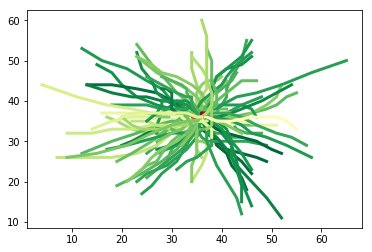

In [13]:
n = hp.num_trials
# colors = plt.cm.jet(accuracies)
colors = plt.cm.RdYlGn((accuracies-np.min(accuracies))/(np.max(accuracies)-np.min(accuracies)))
# 
for trial in range(hp.num_trials):
    plt.plot(trajectories[trial][:,0],trajectories[trial][:,1],  color=colors[trial],linewidth=3)

(array([ 1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  1.,  0.,  5.,  3.,  5.,  3.,  4.,  4., 10., 10.,  9.,  9.,
        17.,  8.,  4.,  5.]),
 array([0.6566    , 0.66455333, 0.67250667, 0.68046   , 0.68841333,
        0.69636667, 0.70432   , 0.71227333, 0.72022667, 0.72818   ,
        0.73613333, 0.74408667, 0.75204   , 0.75999333, 0.76794667,
        0.7759    , 0.78385333, 0.79180667, 0.79976   , 0.80771333,
        0.81566667, 0.82362   , 0.83157333, 0.83952667, 0.84748   ,
        0.85543333, 0.86338667, 0.87134   , 0.87929333, 0.88724667,
        0.8952    ]),
 <a list of 30 Patch objects>)

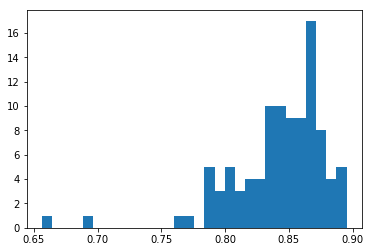

In [22]:
plt.hist(accuracies,bins=30)

In [26]:
accuracies.max()

0.8952

In [40]:
# Set the input shape
input_shape = (1000,)
# print(f'Feature shape: {input_shape}')

# Create the model
model = keras.Sequential()
model.add(keras.layers.Dense(300, input_shape=input_shape, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(100,  activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(10, activation='softmax'))

# Configure the model and start training
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(np.transpose(train_pred_pred,[1,2,0]).reshape([-1,1000]), train_dataset_y.astype(int), epochs=100, batch_size=250, 
          verbose=1, validation_data=(np.transpose(val_pred_pred,[1,2,0]).reshape([-1,1000]), test_dataset_y))


Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 3s 54us/sample - loss: 0.3135 - acc: 0.9235 - val_loss: 0.1593 - val_acc: 0.9570
Epoch 2/100
55000/55000 [==============================] - 2s 42us/sample - loss: 0.1827 - acc: 0.9558 - val_loss: 0.1321 - val_acc: 0.9618
Epoch 3/100
55000/55000 [==============================] - 2s 42us/sample - loss: 0.1525 - acc: 0.9610 - val_loss: 0.1263 - val_acc: 0.9662
Epoch 4/100
55000/55000 [==============================] - 2s 42us/sample - loss: 0.1359 - acc: 0.9648 - val_loss: 0.1284 - val_acc: 0.9650
Epoch 5/100
55000/55000 [==============================] - 2s 42us/sample - loss: 0.1261 - acc: 0.9667 - val_loss: 0.1162 - val_acc: 0.9686
Epoch 6/100
55000/55000 [==============================] - 2s 43us/sample - loss: 0.1157 - acc: 0.9703 - val_loss: 0.1144 - val_acc: 0.9680
Epoch 7/100
55000/55000 [==============================] - 2s 41us/sample - loss: 0.1050 - acc: 0.9722 - val_lo

Epoch 59/100
55000/55000 [==============================] - 2s 43us/sample - loss: 0.0195 - acc: 0.9941 - val_loss: 0.1649 - val_acc: 0.9714
Epoch 60/100
55000/55000 [==============================] - 2s 43us/sample - loss: 0.0147 - acc: 0.9957 - val_loss: 0.1890 - val_acc: 0.9710
Epoch 61/100
55000/55000 [==============================] - 2s 42us/sample - loss: 0.0155 - acc: 0.9956 - val_loss: 0.1865 - val_acc: 0.9714
Epoch 62/100
55000/55000 [==============================] - 2s 42us/sample - loss: 0.0166 - acc: 0.9950 - val_loss: 0.1781 - val_acc: 0.9700
Epoch 63/100
55000/55000 [==============================] - 2s 42us/sample - loss: 0.0140 - acc: 0.9959 - val_loss: 0.1823 - val_acc: 0.9718
Epoch 64/100
55000/55000 [==============================] - 2s 43us/sample - loss: 0.0167 - acc: 0.9954 - val_loss: 0.1855 - val_acc: 0.9724
Epoch 65/100
55000/55000 [==============================] - 2s 41us/sample - loss: 0.0172 - acc: 0.9952 - val_loss: 0.1734 - val_acc: 0.9712
Epoch 66/100
